# Code Assignment 18 — NYC COVID-19 Daily Counts (Time-Series)

**Dataset:** [NYC DOHMH — *COVID-19 Daily Counts of Cases, Hospitalizations, and Deaths*](https://data.cityofnewyork.us/Health/COVID-19-Daily-Counts-of-Cases-Hospitalizations-an/rc75-m7u3/about_data) 
**Focus:** Build a clean **daily** time series, **visualize** with resampling (month-end, yearly), **decompose** (trend/seasonality/residual), and **test stationarity** (ADF).  
**No forecasting models** and **no ACF/PACF** yet.

---

## Instructor Guidance

 Build a clean **daily** time series from NYC COVID-19 data using **SQLite** for filtering; visualize resampled views; run **decomposition** and **ADF**.

### Pseudocode Plan 
1) **Download CSV → pandas** (parse dates) → `pd.read_csv(path, parse_dates=['date_of_interest'])`  
2) **Normalize columns to lowercase** → `df.columns = df.columns.str.lower()`  
3) **Write to SQLite** → `import sqlite3; conn = sqlite3.connect('nyc_ts.db'); df.to_sql('covid_daily', conn, if_exists='replace', index=False)`  
4) **Filter to a time window** (choose recent 12–24 months, select only needed columns)   
5) **Set DateTime index & daily frequency** → `df.set_index('date_of_interest').asfreq('D')`  
6) **Pick ONE target series** (`case_count` | `hosp_count` | `death_count`) and for now fill in missing values with zero 
7) **Resample for EDA**  
   - Month-end totals → `df[[target]].resample('M').sum()`  
   - Yearly totals → use the month-end totals to figure this code out 
8) **Decompose** (weekly seasonality) → `seasonal_decompose()`  
9) **ADF test** (raw → difference)  
   - Raw → `adfuller(s.dropna())`  
   - First difference 
10) **Short write-up**: describe trend/seasonality, ADF p-values before/after differencing, and business implications.


## Your Task

### Step 0:  Run the imports below

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

plt.style.use("seaborn-v0_8-whitegrid")
pd.set_option("display.float_format", lambda x: f"{x:,.3f}")


### Step 1:  Read in the data and look at it

In [2]:
df = pd.read_csv("/Users/kabbo/Downloads/covid copy.csv", low_memory=False)

### Step 2:  Keep needed columns & filter by time window 

- Chose any time window (use most recent data) that is 6 to 12 months long 


In [3]:
df.keys()


Index(['date_of_interest', 'CASE_COUNT', 'PROBABLE_CASE_COUNT',
       'HOSPITALIZED_COUNT', 'DEATH_COUNT', 'CASE_COUNT_7DAY_AVG',
       'ALL_CASE_COUNT_7DAY_AVG', 'HOSP_COUNT_7DAY_AVG',
       'DEATH_COUNT_7DAY_AVG', 'BX_CASE_COUNT', 'BX_PROBABLE_CASE_COUNT',
       'BX_HOSPITALIZED_COUNT', 'BX_DEATH_COUNT', 'BX_CASE_COUNT_7DAY_AVG',
       'BX_PROBABLE_CASE_COUNT_7DAY_AVG', 'BX_ALL_CASE_COUNT_7DAY_AVG',
       'BX_HOSPITALIZED_COUNT_7DAY_AVG', 'BX_DEATH_COUNT_7DAY_AVG',
       'BK_CASE_COUNT', 'BK_PROBABLE_CASE_COUNT', 'BK_HOSPITALIZED_COUNT',
       'BK_DEATH_COUNT', 'BK_CASE_COUNT_7DAY_AVG',
       'BK_PROBABLE_CASE_COUNT_7DAY_AVG', 'BK_ALL_CASE_COUNT_7DAY_AVG',
       'BK_HOSPITALIZED_COUNT_7DAY_AVG', 'BK_DEATH_COUNT_7DAY_AVG',
       'MN_CASE_COUNT', 'MN_PROBABLE_CASE_COUNT', 'MN_HOSPITALIZED_COUNT',
       'MN_DEATH_COUNT', 'MN_CASE_COUNT_7DAY_AVG',
       'MN_PROBABLE_CASE_COUNT_7DAY_AVG', 'MN_ALL_CASE_COUNT_7DAY_AVG',
       'MN_HOSPITALIZED_COUNT_7DAY_AVG', 'MN_DEATH_COUNT_7

In [4]:
# CELL 2 — Keep needed columns & filter by date in Pandas (no SQL)

# 1) Normalize column names
df.columns = df.columns.str.lower()

# 2) Parse date column
df['date_of_interest'] = pd.to_datetime(df['date_of_interest'])

# 3) Keep only needed columns
cols = ['date_of_interest', 'case_count', 'hospitalized_count', 'death_count']
df = df[cols]

df.head()
df.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2054 entries, 0 to 2053
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   date_of_interest    2054 non-null   datetime64[ns]
 1   case_count          2054 non-null   object        
 2   hospitalized_count  2054 non-null   object        
 3   death_count         2054 non-null   int64         
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 64.3+ KB


### Step 3:  Create a time series object and pick your Y (case count, hospitalized count, death count, etc)

- Use the `date_of_interest` column as your index and keep it at "Daily" frequency (try looking up set_index() in pandas)
- Fill in missing values of Y with zero 

In [5]:
#Build a daily time series, pick a target metric
# Set time index & ensure daily frequency

# Convert numeric columns from object → int
df['case_count'] = pd.to_numeric(df['case_count'], errors='coerce')
df['hospitalized_count'] = pd.to_numeric(df['hospitalized_count'], errors='coerce')

# Set time index
df = df.set_index('date_of_interest').sort_index()

# Ensure a continuous daily date range
df = df.asfreq('D')

# Pick your Y variable (example: case_count)
Y = df['case_count'].fillna(0)

# If you want the entire dataset to have zeros for missing
df = df.fillna(0)

# Show result
print(df.head())
print(df.tail())


                  case_count  hospitalized_count  death_count
date_of_interest                                             
2020-02-29             1.000               1.000            0
2020-03-01             0.000               1.000            0
2020-03-02             0.000               2.000            0
2020-03-03             1.000               7.000            0
2020-03-04             5.000               2.000            0
                  case_count  hospitalized_count  death_count
date_of_interest                                             
2025-10-09           108.000               4.000            2
2025-10-10            87.000               2.000            0
2025-10-11            69.000               1.000            0
2025-10-12            71.000               1.000            0
2025-10-13            61.000               0.000            0


In [6]:
df['case_count'] = pd.to_numeric(df['case_count'], errors='coerce')
df['hospitalized_count'] = pd.to_numeric(df['hospitalized_count'], errors='coerce')


In [8]:
df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2054 entries, 2020-02-29 to 2025-10-13
Freq: D
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   case_count          2054 non-null   float64
 1   hospitalized_count  2054 non-null   float64
 2   death_count         2054 non-null   int64  
dtypes: float64(2), int64(1)
memory usage: 64.2 KB


,case_count,hospitalized_count,death_count
date_of_interest,,,
2020-02-29,1.000,1.000,0
2020-03-01,0.000,1.000,0
2020-03-02,0.000,2.000,0
2020-03-03,1.000,7.000,0
2020-03-04,5.000,2.000,0


### Step 4 - Visualize the Series

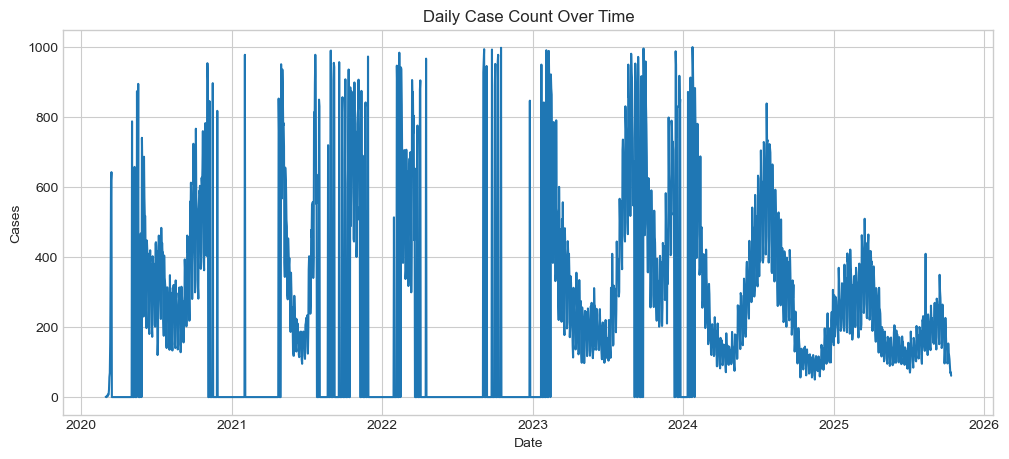

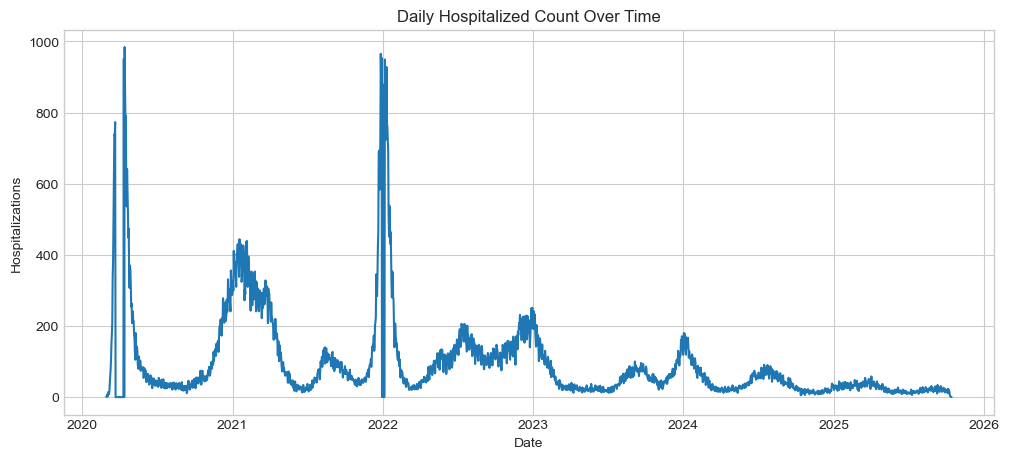

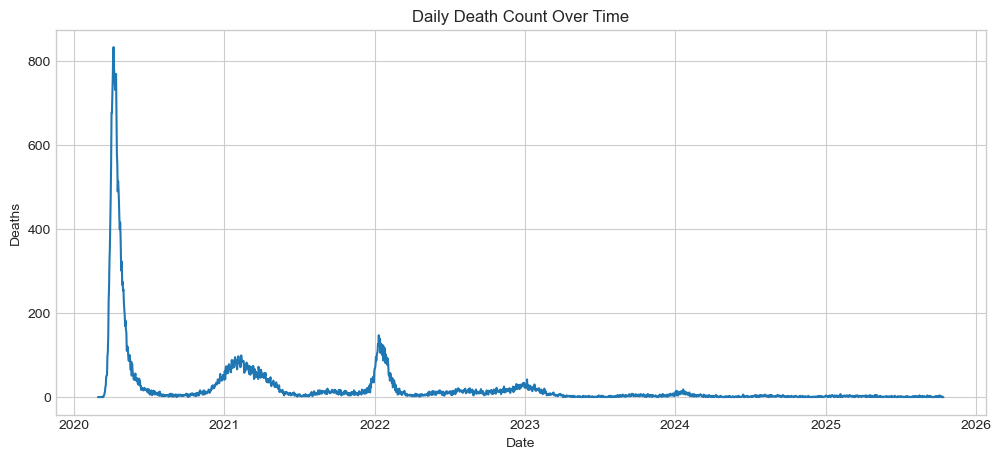

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(df.index, df['case_count'])
plt.title('Daily Case Count Over Time')
plt.xlabel('Date')
plt.ylabel('Cases')
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(df.index, df['hospitalized_count'])
plt.title('Daily Hospitalized Count Over Time')
plt.xlabel('Date')
plt.ylabel('Hospitalizations')
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(df.index, df['death_count'])
plt.title('Daily Death Count Over Time')
plt.xlabel('Date')
plt.ylabel('Deaths')
plt.show()


### Step 5 - Resampling EDA:  Month-end and Yearly totals 

- Use the `.resample()` function to resample the series to month end and yearly 
- Visualize both resampled series 

In [ ]:
# CELL 5 — Resampling EDA: Month-end and Yearly totals (Pandas-only)

# Month-end totals 
m_end = df.resample('ME').sum()

# Year-end totals 
y_sum = df.resample('YE').sum()

print("Month-end totals:")
print(m_end.head())

print("\nYearly totals:")
print(y_sum.head())


Month-end totals:
                  case_count  hospitalized_count  death_count   case_ma7
date_of_interest                                                        
2020-02-29             1.000               1.000            0      0.000
2020-03-31         1,942.000           4,973.000         2638  1,939.857
2020-04-30             0.000          10,089.000        16689      0.000
2020-05-31         8,499.000           3,945.000         3267  7,201.857
2020-06-30        10,845.000           1,534.000          749 11,114.857

Yearly totals:
                  case_count  hospitalized_count  death_count    case_ma7
date_of_interest                                                         
2020-12-31        72,251.000          36,117.000        25498  72,247.857
2021-12-31        69,454.000          58,994.000        10404  69,454.000
2022-12-31        40,013.000          52,229.000         8063  40,013.000
2023-12-31       128,375.000          20,739.000         1871 128,375.000
2024-12-31 

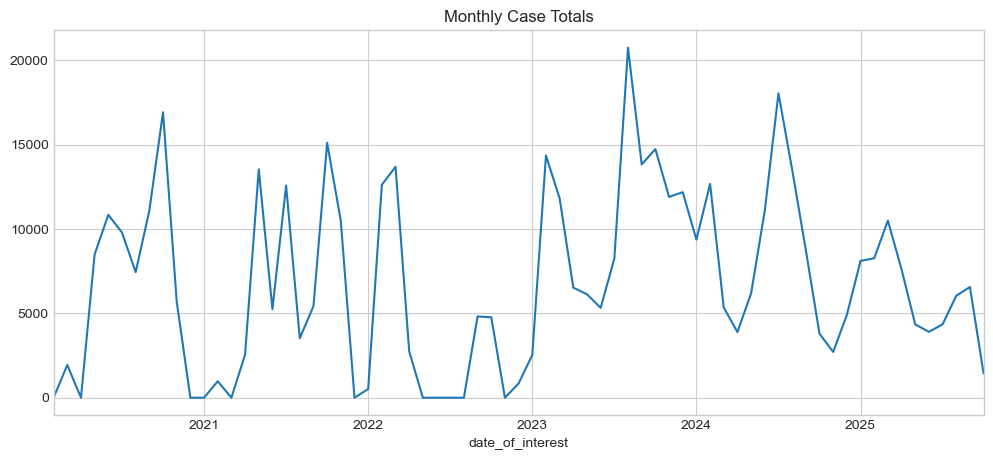

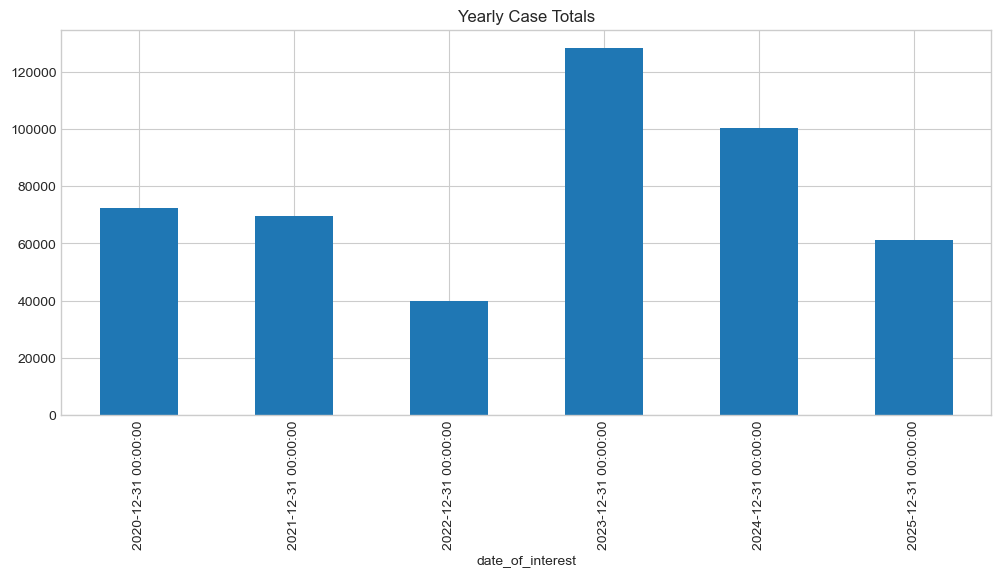

In [ ]:
# Viz 

plt.show()

y_sum['case_count'].plot(kind='bar', figsize=(12,5), title="Yearly Case Totals")
plt.show()


### Step 6 - Decompose the original time series object (use period = 7 since that represents weekly seasonality)
- Make a visual of the decomposition

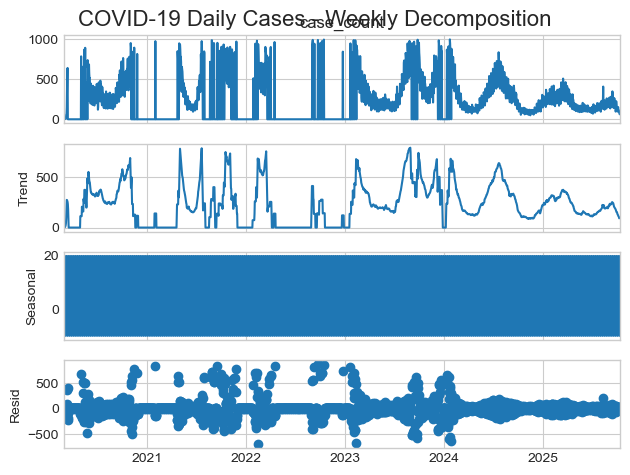

In [20]:
# CELL 6 — Decomposition (weekly seasonality → period=7)
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Pick target series
target = 'case_count'

# Decompose the series (weekly seasonality)
decomp = seasonal_decompose(df[target], model='additive', period=7)

# Plot decomposition
decomp.plot()
plt.suptitle("COVID-19 Daily Cases - Weekly Decomposition", fontsize=16)
plt.show()



### Step 7 - Do the ADF test for stationarity on the original time series and for taking a difference of 1 on the time series 
- Be sure to drop missing values (if you didn't above) 

In [ ]:
# CELL 7 — ADF stationarity test: raw → difference (1) → (optional) seasonal diff(7)
from statsmodels.tsa.stattools import adfuller

target = 'case_count'

# Raw series
s_raw = df[target].dropna()
adf_raw = adfuller(s_raw)
print("ADF Test (Raw):")
print(f"ADF Statistic: {adf_raw[0]:.4f}, p-value: {adf_raw[1]:.4f}")

# diff 1
s_diff1 = s_raw.diff().dropna()
adf_diff1 = adfuller(s_diff1)
print("\nADF Test (1st Difference):")
print(f"ADF Statistic: {adf_diff1[0]:.4f}, p-value: {adf_diff1[1]:.4f}")



ADF Test (Raw):
ADF Statistic: -5.4050, p-value: 0.0000

ADF Test (1st Difference):
ADF Statistic: -10.3320, p-value: 0.0000


## We Share — Reflection 

1) **Narrative:** One sentence describing the series over your window (trend + weekly seasonality + volatility).  
2) **Stationarity:** Which transform (if any) produced p < 0.05? Why does that matter before modeling?  
3) **Operational lens:** Based on month-end and yearly views, what **calendar effects** would you brief stakeholders about?


**Narrative:** The NYC daily COVID-19 cases series shows clear upward and downward waves, and volatile spikes likely due to reporting lags.

**Stationarity:** The raw series and first difference all produced p < 0.05, indicating stationarity. This matters because many time series models assume a stationary input; stationary data ensures reliable trend and pattern modeling.

**Operational lens:** Month-end and yearly totals reveal seasonal surges and dips. It seems there are lower counts during specific times of the months (most likely holidasy and weekends) and higher counts in certain waves. Therefore, stakeholders should account for weekly reporting patterns and annual peaks when planning resource allocation, hospital staffing, or public health alerts.